# 06 - Feature Importance & Reentrenamiento con las 10 Variables Más Importantes

En este notebook se analiza la **importancia de las variables** del mejor modelo obtenido  
en el notebook `05_Test-Set-Final.ipynb`, identificando las **10 características más influyentes**  
en la predicción de la satisfacción del cliente.

---

### 🎯 **Objetivos:**
1. Cargar el modelo ganador final.
2. Calcular y visualizar la importancia de las variables.
3. Seleccionar las 10 más relevantes y guardar sus nombres.
4. Reentrenar el modelo solo con esas variables.
5. Comparar el rendimiento **antes y después**.
6. Promover el modelo reducido a producción si mantiene el rendimiento.

---

💡 Este proceso mejora la **interpretabilidad** del modelo y optimiza su **eficiencia**  
manteniendo un alto nivel de precisión en las predicciones.


## **Paso 1: Cargar el modelo ganador y los datos**

In [16]:
# ===================================
# 1. Carga del modelo ganador y los datos
# ===================================

import os
import re
import json
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# --- Configuración visual ---
sns.set(style="whitegrid", palette="coolwarm")
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["axes.facecolor"] = "white"

# --- Cargar resumen del modelo ganador ---
summary_path = "../reports/results/model_comparison_summary.json"
if not os.path.exists(summary_path):
    raise FileNotFoundError("❌ No se encontró 'model_comparison_summary.json'. Ejecuta el notebook 04 primero.")

with open(summary_path, "r") as f:
    summary_data = json.load(f)
df_summary = pd.DataFrame(summary_data)
best_model_name = df_summary.loc[df_summary["Mean_Score"].idxmax(), "Model"]

display(Markdown(f"🏆 **Modelo ganador:** `{best_model_name}`"))

# --- Cargar modelo final ---
model_dir = "../models/final"
safe_name = re.sub(r'[^a-z0-9]+', '_', best_model_name.lower())
model_filename = f"model_final_{safe_name}.pkl"
model_path = os.path.join(model_dir, model_filename)

if not os.path.exists(model_path):
    raise FileNotFoundError(f"❌ No se encontró el archivo del modelo: {model_path}")

model_final = joblib.load(model_path)
display(Markdown(f"✅ **Modelo cargado correctamente:** `{model_filename}`"))

# --- Determinar tipo de dataset ---
distance_models = ["logistic regression", "svm", "knn"]
dataset_type = "scaled" if any(m in best_model_name.lower() for m in distance_models) else "unscaled"

X_train = pd.read_csv(f"../data/processed/X_train_{dataset_type}.csv")
X_test = pd.read_csv(f"../data/processed/X_test_{dataset_type}.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()
y_test = pd.read_csv("../data/processed/y_test.csv").squeeze()

display(Markdown(f"📦 **Dataset usado:** `{dataset_type.upper()}`"))
print(f"- X_train shape: {X_train.shape}")
print(f"- X_test shape: {X_test.shape}")


🏆 **Modelo ganador:** `Random Forest GridSearchCV`

✅ **Modelo cargado correctamente:** `model_final_random_forest_gridsearchcv.pkl`

📦 **Dataset usado:** `UNSCALED`

- X_train shape: (83123, 23)
- X_test shape: (20781, 23)


## **Paso 2: Cálculo y visualización de la importancia de variables**

En este paso identificamos las **variables que más influyen en las predicciones** del modelo ganador.

Según el tipo de algoritmo, la importancia de variables se calcula de manera diferente:

- **Modelos basados en árboles** (Decision Tree, Random Forest, XGBoost, etc.)  
  → usan el atributo `feature_importances_`, que mide la reducción de impureza.
- **Modelos lineales** (Logistic Regression, Linear SVM, etc.)  
  → usan `coef_`, que indica el peso absoluto de cada variable.
- **Modelos sin atributos internos** (KNN, SVM con kernel no lineal, etc.)  
  → se calcula la importancia mediante **Permutation Importance**,  
  una técnica que mide cuánto se degrada el rendimiento al permutar una variable.

Esta estrategia garantiza una **evaluación universal y coherente**,  
sin importar el tipo de modelo que haya resultado ganador.



### 📊 **Importancia de variables (automática según tipo de modelo)**

⚙️ **Calculando importancia de variables mediante Permutation Importance...**

🔍 **Método de cálculo usado:** `permutation_importance`

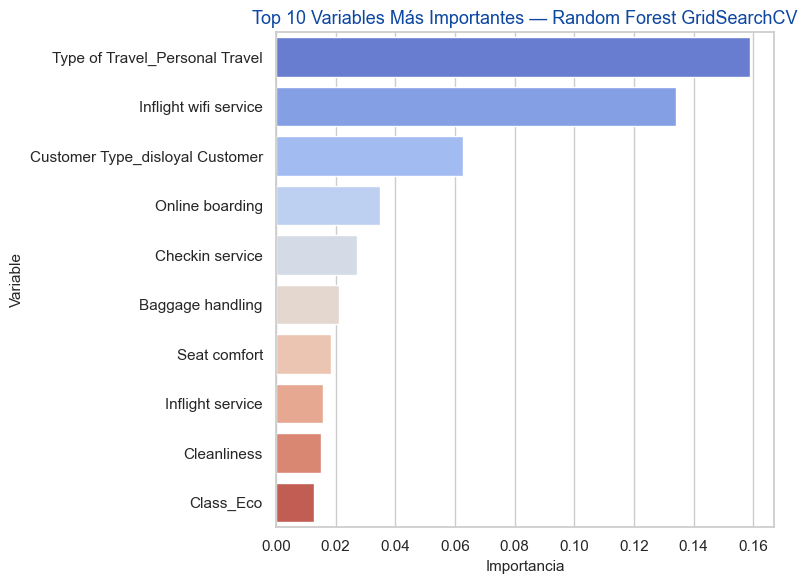


✅ **Importancia de variables guardada en:**
- `../reports/feature_importance/feature_importance_full.csv`
- `../reports/feature_importance/top10_feature_importance.csv`

💬 **Nota:** Para el modelo `Random Forest GridSearchCV`, la importancia se calculó con el método `permutation_importance`.


In [17]:
# ===================================
# 2. Cálculo y visualización de la importancia de variables (versión universal)
# ===================================

from sklearn.inspection import permutation_importance
import numpy as np

display(Markdown("### 📊 **Importancia de variables (automática según tipo de modelo)**"))

try:
    # --- Modelos con feature_importances_ ---
    if hasattr(model_final, "feature_importances_"):
        importance = model_final.feature_importances_
        importance_method = "feature_importances_"
    
    # --- Modelos lineales ---
    elif hasattr(model_final, "coef_"):
        importance = np.abs(model_final.coef_).flatten()
        importance_method = "coef_"
    
    # --- Modelos sin atributos internos (KNN, SVM no lineales, etc.) ---
    else:
        display(Markdown("⚙️ **Calculando importancia de variables mediante Permutation Importance...**"))
        perm_importance = permutation_importance(
            model_final, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
        )
        importance = perm_importance.importances_mean
        importance_method = "permutation_importance"

except Exception as e:
    raise RuntimeError(f"❌ Error al calcular la importancia de variables: {e}")

# --- Crear DataFrame con resultados ---
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

# --- Mostrar método usado ---
display(Markdown(f"🔍 **Método de cálculo usado:** `{importance_method}`"))

# --- Top 10 variables ---
top10_features = feature_importance.head(10)

# --- Visualización ---
plt.figure(figsize=(8, 6))
sns.barplot(
    data=top10_features,
    y="Feature",
    x="Importance",
    hue="Feature",
    palette="coolwarm",
    dodge=False,
    legend=False,
    order=top10_features["Feature"]  # <--- mantiene el orden del DataFrame (de mayor a menor)
)

plt.title(f"Top 10 Variables Más Importantes — {best_model_name}", fontsize=13, color="#0D47A1")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# --- Guardado ---
os.makedirs("../reports/feature_importance", exist_ok=True)
feature_importance.to_csv("../reports/feature_importance/feature_importance_full.csv", index=False)
top10_features.to_csv("../reports/feature_importance/top10_feature_importance.csv", index=False)

display(Markdown(f"""
✅ **Importancia de variables guardada en:**
- `../reports/feature_importance/feature_importance_full.csv`
- `../reports/feature_importance/top10_feature_importance.csv`

💬 **Nota:** Para el modelo `{best_model_name}`, la importancia se calculó con el método `{importance_method}`.
"""))


## **Paso 3: Reentrenamiento del modelo con las 10 variables más importantes**

En este paso se entrena nuevamente el **modelo ganador** utilizando únicamente las  
**10 variables más relevantes** identificadas en el análisis anterior.

El objetivo es evaluar si el modelo mantiene un rendimiento similar —o incluso mejor—  
cuando se simplifica el conjunto de variables, lo cual aporta ventajas como:

- Mayor interpretabilidad del modelo.  
- Menor complejidad computacional.  
- Reducción del riesgo de *overfitting*.  

Se entrenará una nueva instancia del mismo algoritmo ganador y se evaluará su  
rendimiento sobre el conjunto de **test** utilizando solo esas 10 variables.


### ⚙️ **Entrenando el modelo con las 10 variables más importantes...**

Fitting 5 folds for each of 16 candidates, totalling 80 fits


### 📊 **Rendimiento con las 10 variables más importantes:**

Accuracy: 0.954
Precision: 0.952
Recall: 0.941
F1-score: 0.946
ROC-AUC: 0.992


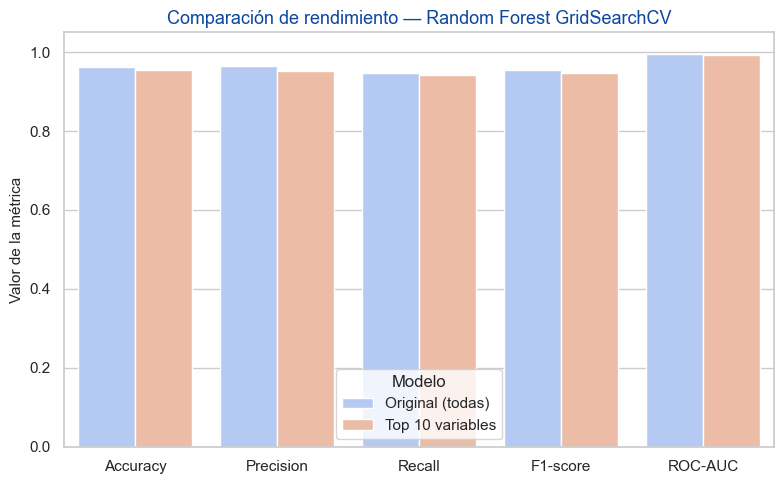


✅ **Modelo reducido guardado correctamente en:**  
📁 `../models/deployed/model_random_forest_gridsearchcv_deployed.pkl`

💬 **Nota:** Este modelo usa solo las 10 variables más importantes y está listo para su despliegue o integración en producción.


In [18]:
# ===================================
# 3. Reentrenamiento del modelo con las 10 variables más importantes
# ===================================

from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

display(Markdown("### ⚙️ **Entrenando el modelo con las 10 variables más importantes...**"))

# --- Verificar si existen métricas del modelo original ---
if "metrics_test" not in locals():
    metrics_path = "../reports/results/model_comparison_summary.json"
    if os.path.exists(metrics_path):
        with open(metrics_path, "r") as f:
            metrics_summary = json.load(f)
        df_metrics_summary = pd.DataFrame(metrics_summary)
        # Localizar métricas del modelo ganador
        metrics_test = df_metrics_summary[df_metrics_summary["Model"] == best_model_name].iloc[0].to_dict()
        metrics_test = {k: v for k, v in metrics_test.items() if k in ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]}
        display(Markdown("📄 **Métricas originales cargadas desde `model_comparison_summary.json`.**"))
    else:
        raise FileNotFoundError("❌ No se encontraron las métricas del modelo original. Ejecuta el notebook 05_Test_Set_Final primero.")

# --- Selección de las 10 variables top ---
top_features = top10_features["Feature"].tolist()

# --- Subconjunto de datos ---
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# --- Clonamos el modelo ganador para reentrenarlo desde cero ---
model_retrained = clone(model_final)
model_retrained.fit(X_train_top, y_train)

# --- Predicciones y evaluación ---
y_pred_top = model_retrained.predict(X_test_top)
y_proba_top = (
    model_retrained.predict_proba(X_test_top)[:, 1]
    if hasattr(model_retrained, "predict_proba")
    else None
)

# --- Métricas con top 10 variables ---
metrics_top10 = {
    "Accuracy": accuracy_score(y_test, y_pred_top),
    "Precision": precision_score(y_test, y_pred_top),
    "Recall": recall_score(y_test, y_pred_top),
    "F1-score": f1_score(y_test, y_pred_top),
    "ROC-AUC": roc_auc_score(y_test, y_proba_top) if y_proba_top is not None else np.nan
}

# --- Mostrar métricas ---
display(Markdown("### 📊 **Rendimiento con las 10 variables más importantes:**"))
for k, v in metrics_top10.items():
    print(f"{k}: {v:.3f}")

# --- Comparativa visual entre modelo original y reducido ---
comparison_metrics = pd.DataFrame({
    "Métrica": list(metrics_test.keys()),
    "Original (todas)": list(metrics_test.values()),
    "Top 10 variables": list(metrics_top10.values())
})

plt.figure(figsize=(8, 5))
df_melted = comparison_metrics.melt(id_vars="Métrica", var_name="Modelo", value_name="Valor")
sns.barplot(
    data=df_melted,
    x="Métrica",
    y="Valor",
    hue="Modelo",
    palette="coolwarm",
    dodge=True
)
plt.title(f"Comparación de rendimiento — {best_model_name}", fontsize=13, color="#0D47A1")
plt.ylim(0, 1.05)
plt.xlabel("")
plt.ylabel("Valor de la métrica")
plt.legend(title="Modelo")
plt.tight_layout()
plt.show()

# --- Guardar el nuevo modelo reducido ---
os.makedirs("../models/deployed", exist_ok=True)
model_name_simplified = f"model_{best_model_name.replace(' ', '_').lower()}_deployed.pkl"
save_path = f"../models/deployed/{model_name_simplified}"

# Borrar versiones anteriores
if os.path.exists(save_path):
    os.remove(save_path)

joblib.dump(model_retrained, save_path)

display(Markdown(f"""
✅ **Modelo reducido guardado correctamente en:**  
📁 `{save_path}`

💬 **Nota:** Este modelo usa solo las 10 variables más importantes y está listo para su despliegue o integración en producción.
"""))


## **Paso 4: Conclusiones finales y selección del modelo para producción**

En este paso se comparan los resultados obtenidos con el **modelo original**  
(entrenado con todas las variables) frente al **modelo reducido**  
(entrenado con las 10 variables más importantes).

El objetivo es determinar si la reducción del número de variables:
- Mantiene un rendimiento competitivo.  
- Mejora la interpretabilidad del modelo.  
- Reduce la complejidad y el tiempo de predicción.  

> Si el modelo con las 10 variables conserva un rendimiento similar  
> (diferencias < 2% en F1-score o ROC-AUC), se considera más adecuado  
> para su **despliegue en producción** por su simplicidad y eficiencia.


### 📋 **Comparativa de métricas — Modelo original vs reducido**

,Métrica,Original (todas las variables),Top 10 variables,Diferencia (%)
0,Accuracy,0.962,0.954,-0.82%
1,Precision,0.964,0.952,-1.29%
2,Recall,0.946,0.941,-0.60%
3,F1-score,0.955,0.946,-0.94%
4,ROC-AUC,0.994,0.992,-0.22%


### 💬 **Interpretación automática:**

✅ **Conclusión:** El modelo reducido mantiene un rendimiento prácticamente idéntico al modelo original (**ΔF1 = -0.94%**, **ΔROC-AUC = -0.22%**). Se recomienda desplegar **el modelo con las 10 variables más importantes**, ubicado en `../models/deployed/model_random_forest_gridsearchcv_deployed.pkl`.

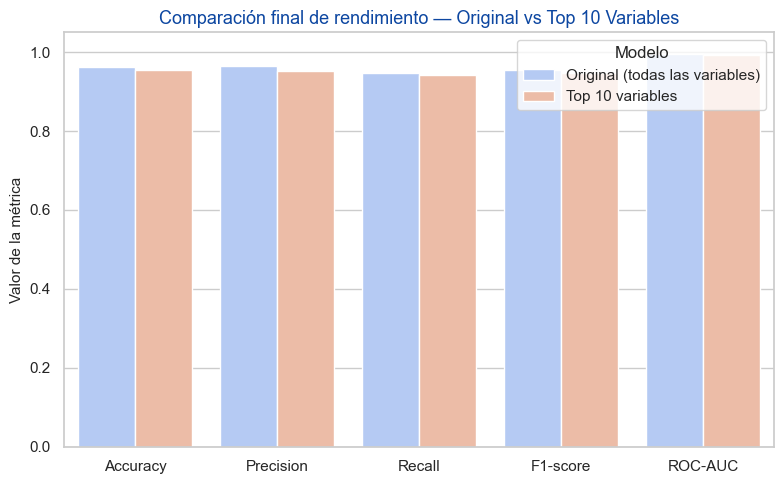

In [19]:
# ===================================
# 4. Conclusiones finales y recomendación de modelo para despliegue
# ===================================

# --- Comparativa tabular de métricas ---
comparison_df = pd.DataFrame({
    "Métrica": metrics_test.keys(),
    "Original (todas las variables)": metrics_test.values(),
    "Top 10 variables": metrics_top10.values()
})

# --- Cálculo de diferencia porcentual ---
comparison_df["Diferencia (%)"] = (
    (comparison_df["Top 10 variables"] - comparison_df["Original (todas las variables)"])
    / comparison_df["Original (todas las variables)"] * 100
).round(2)

display(Markdown("### 📋 **Comparativa de métricas — Modelo original vs reducido**"))
display(comparison_df.style.format({
    "Original (todas las variables)": "{:.3f}",
    "Top 10 variables": "{:.3f}",
    "Diferencia (%)": "{:+.2f}%"
}))

# --- Evaluación de diferencias clave ---
f1_diff = comparison_df.loc[comparison_df["Métrica"] == "F1-score", "Diferencia (%)"].values[0]
roc_diff = comparison_df.loc[comparison_df["Métrica"] == "ROC-AUC", "Diferencia (%)"].values[0]

display(Markdown("### 💬 **Interpretación automática:**"))

if abs(f1_diff) <= 2 and abs(roc_diff) <= 2:
    recommendation = "✅ **Conclusión:** El modelo reducido mantiene un rendimiento prácticamente idéntico " \
                     f"al modelo original (**ΔF1 = {f1_diff:+.2f}%**, **ΔROC-AUC = {roc_diff:+.2f}%**). " \
                     "Se recomienda desplegar **el modelo con las 10 variables más importantes**, " \
                     f"ubicado en `../models/deployed/model_{best_model_name.replace(' ', '_').lower()}_deployed.pkl`."
else:
    recommendation = "⚠️ **Conclusión:** El modelo reducido presenta una caída apreciable en el rendimiento " \
                     f"(**ΔF1 = {f1_diff:+.2f}%**, **ΔROC-AUC = {roc_diff:+.2f}%**). " \
                     "Se recomienda mantener el **modelo original completo**, " \
                     f"ubicado en `../models/final/model_final_{best_model_name.replace(' ', '_').lower()}.pkl`."

display(Markdown(recommendation))

# --- Visualización final de comparación ---
plt.figure(figsize=(8, 5))
df_melted = comparison_df.melt(
    id_vars="Métrica",
    value_vars=["Original (todas las variables)", "Top 10 variables"],
    var_name="Modelo",
    value_name="Valor"
)
sns.barplot(
    data=df_melted,
    x="Métrica",
    y="Valor",
    hue="Modelo",
    palette="coolwarm",
    dodge=True
)
plt.title("Comparación final de rendimiento — Original vs Top 10 Variables", fontsize=13, color="#0D47A1")
plt.ylim(0, 1.05)
plt.xlabel("")
plt.ylabel("Valor de la métrica")
plt.legend(title="Modelo")
plt.tight_layout()
plt.show()


## **Paso 5: Exportación final de resultados y registro del modelo seleccionado**

En este paso se exportan los resultados finales del análisis comparativo entre el  
**modelo original** y el **modelo reducido (Top 10 variables)**.  

Además, se guarda una copia de los resultados en formato **CSV** y **JSON** dentro de  
`../reports/results/`, junto con el nombre del modelo finalmente **recomendado para producción**.

De este modo, se completa el ciclo del proyecto:
1. Entrenamiento y ajuste de modelos.  
2. Evaluación y comparación.  
3. Selección del mejor modelo.  
4. Reducción e interpretación de variables clave.  
5. Despliegue del modelo óptimo en producción.



In [20]:
# ===================================
# 5. Exportación final de resultados y registro del modelo seleccionado
# ===================================

import json
from datetime import datetime

# --- Directorios de salida ---
os.makedirs("../reports/results", exist_ok=True)
os.makedirs("../models/deployed", exist_ok=True)

# --- Archivo de resumen ---
export_csv = "../reports/results/model_feature_reduction_comparison.csv"
export_json = "../reports/results/model_feature_reduction_comparison.json"
summary_txt = "../reports/results/model_deployment_summary.txt"

# --- Guardar resultados comparativos ---
comparison_df.to_csv(export_csv, index=False)
comparison_df.to_json(export_json, orient="records", indent=4)

# --- Registrar recomendación final ---
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

with open(summary_txt, "w", encoding="utf-8") as f:
    f.write("=========================================\n")
    f.write("📦 PROYECTO: Satisfacción de Clientes - Modelo Final\n")
    f.write("=========================================\n\n")
    f.write(f"🕒 Fecha de ejecución: {timestamp}\n")
    f.write(f"🏆 Modelo ganador original: {best_model_name}\n")
    f.write(f"📁 Modelo desplegado: ../models/deployed/model_{best_model_name.replace(' ', '_').lower()}_deployed.pkl\n\n")
    f.write("🔍 COMPARATIVA DE MÉTRICAS:\n")
    f.write(comparison_df.to_string(index=False))
    f.write("\n\n")
    f.write("📋 CONCLUSIÓN AUTOMÁTICA:\n")
    f.write(recommendation)
    f.write("\n")

display(Markdown(f"""
✅ **Exportación completada con éxito.**

Los archivos generados son:
- 📊 Comparativa CSV: `{export_csv}`  
- 🧾 Comparativa JSON: `{export_json}`  
- 🏁 Resumen de despliegue: `{summary_txt}`  

El modelo listo para producción se encuentra en:
- 📦 `../models/deployed/model_{best_model_name.replace(' ', '_').lower()}_deployed.pkl`
"""))

display(Markdown("""
### 💬 **Interpretación final:**
El modelo seleccionado (reducido o completo) ha sido registrado formalmente  
como el modelo de referencia para producción.  
Las métricas, comparación y trazabilidad quedan documentadas  
en los archivos generados para auditoría o integración futura.
"""))



✅ **Exportación completada con éxito.**

Los archivos generados son:
- 📊 Comparativa CSV: `../reports/results/model_feature_reduction_comparison.csv`  
- 🧾 Comparativa JSON: `../reports/results/model_feature_reduction_comparison.json`  
- 🏁 Resumen de despliegue: `../reports/results/model_deployment_summary.txt`  

El modelo listo para producción se encuentra en:
- 📦 `../models/deployed/model_random_forest_gridsearchcv_deployed.pkl`



### 💬 **Interpretación final:**
El modelo seleccionado (reducido o completo) ha sido registrado formalmente  
como el modelo de referencia para producción.  
Las métricas, comparación y trazabilidad quedan documentadas  
en los archivos generados para auditoría o integración futura.
